In [3]:
import pandas as pd
import numpy as np
from scipy import spatial
import random as rand
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown as md

In [4]:
rand.seed(42)

In [5]:
N=5000 # number of people
N_days = 200 # Number of simulated days
NB_STO_PER_HOU = 20 # Let's say we have 20 houses for each grocerie store
PROBA_SAME_HOUSE_RATE = 10/100 # probability used to set the number of person per house
PROB_INFECTION_AT_HOME = 0.5 # Probabilty of infecting a random family member (same house)
PROB_INFECTION_AT_WORK = 0.1 # Probabilty of infecting a random co-worker
PROB_INFECTION_AT_STORE = 0.05 # Probabilty of infecting someone who goes to the same store
TPE_MAX_EMPLOYEES = 3
PME_MAX_EMPLOYEES = 15
GE_MAX_EMPLOYEES = 50
DISPLAY = False

In [6]:
IMMUNE_STATE = -2
HEALTHY_STATE = -1
DEAD_STATE = 0

In [7]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [8]:
def getR():
    return rand.random()

In [9]:
def lazyRChoice(ll):
    for l in ll:
        if len(l) > 0:
            yield rand.choice(l)

In [10]:
def getInfectionParameters():
    return int(21+ (39-21)*getR()), int(2+ (7-2)*getR()) # Time to death/immunity , Time to contagiosity

In [11]:
def updateInfectionPeriod(who_is_infected, incubation_dic, contagion_dic):
    for i in who_is_infected:
        if incubation_dic[i] == HEALTHY_STATE: # If has never been infected
            incubation, contagion = getInfectionParameters()
            incubation_dic[i] = incubation
            contagion_dic[i] = contagion

# We gather a mortality rate by age (ten year increments)

In [12]:
# Source : https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/
mortality_rate = {
    8: 0.148, 
    7: 0.08, 
    6: 0.036, 
    5: 0.013, # 50-59 yo => 0.013 probability of dying
    4: 0.04, 
    3: 0.02, 
    2: 0.02, 
    1: 0.02, 
    0: 0
}

In [13]:
def getMortaltyRate(age):
    i = next(x for x in enumerate(list(mortality_rate.keys())) if x[1] <= age/10)
    return  mortality_rate[i[1]]

In [14]:
def getInfectedPeople(incubation_dic):
    return [k for k,v in incubation_dic.items() if v > DEAD_STATE]

In [15]:
def getDeadPeople(incubation_dic):
    return [k for k,v in incubation_dic.items() if v == DEAD_STATE]

In [16]:
def getHealthyPeople(incubation_dic):
    return [k for k,v in incubation_dic.items() if v == HEALTHY_STATE]

In [17]:
def getImmunePeople(incubation_dic):
    return [k for k,v in incubation_dic.items() if v == IMMUNE_STATE]

In [18]:
def incrementInfectionDay(incubation_dic, age_dic, contagion_dic):
    for i in getInfectedPeople(incubation_dic):
        contagion_dic[i] = contagion_dic[i] -1
        if incubation_dic[i] > DEAD_STATE + 1:
            incubation_dic[i] = incubation_dic[i] -1
        if incubation_dic[i] == DEAD_STATE + 1: # Decide over life
            if getR() < getMortaltyRate(age_dic[i]):
                incubation_dic[i] = 0
            else:
                incubation_dic[i] = -2 # Grant immunity

In [19]:
def isContagious(ind, contagion_dic):
    return contagion_dic[ind] < 0

# We will try to avoid O(n²) as much as possible, ideally O(n.log(n))

# Let's build a probability function to assign a coherent age to each individual

In [20]:
# Source https://www.populationpyramid.net/world/2019/
age_distribution = pd.DataFrame([
    ["0-4",349247348,328119059], 
    ["5-9",341670620,320090537],
    ["10-14",328942130,307203261], 
    ["15-19",314806147,293931999], 
    ["20-24",307809031,288834393], 
    ["25-29",307548367,290783757], 
    ["30-34",305762271,293702434], 
    ["35-39",270507560,262936512], 
    ["40-44",247594384,242696599], 
    ["45-49",239897308,237022350], 
    ["50-54",218833001,219504648], 
    ["55-59",187135108,190624979], 
    ["60-64",153758680,161570707], 
    ["65-69",124471230,136004171], 
    ["70-74",82793263,96515002], 
    ["75-79",53073892,66973202], 
    ["80-84",33071682,47305811], 
    ["85-89",15423679,25733670], 
    ["90-94",5370654,11222622], 
    ["95-99",1203726,3239297], 
    ["100-125",114528,418582]], columns=['age', 'nb_men', 'nb_women'])
age_distribution['nb'] = age_distribution['nb_men'] + age_distribution['nb_women']
age_distribution['pct'] = age_distribution['nb'] / age_distribution['nb'].sum()
age_distribution['min_age'] = age_distribution['age'].map(lambda s:int(s.split('-')[0]))
age_distribution['max_age'] = age_distribution['age'].map(lambda s:int(s.split('-')[1]))

# We need to separate adults and children

In [21]:
# We did a cut to 25 years old for adult
age_distribution_children = age_distribution.iloc[:7]
age_distribution_adults = age_distribution.iloc[4:]

In [22]:
age_distribution_children

,age,nb_men,nb_women,nb,pct,min_age,max_age
0,0-4,349247348,328119059,677366407,0.087816,0,4
1,5-9,341670620,320090537,661761157,0.085793,5,9
2,10-14,328942130,307203261,636145391,0.082472,10,14
3,15-19,314806147,293931999,608738146,0.078919,15,19
4,20-24,307809031,288834393,596643424,0.077351,20,24
5,25-29,307548367,290783757,598332124,0.077570,25,29
6,30-34,305762271,293702434,599464705,0.077717,30,34


In [23]:
age_distribution_adults

,age,nb_men,nb_women,nb,pct,min_age,max_age
4,20-24,307809031,288834393,596643424,0.077351,20,24
5,25-29,307548367,290783757,598332124,0.077570,25,29
6,30-34,305762271,293702434,599464705,0.077717,30,34
7,35-39,270507560,262936512,533444072,0.069157,35,39
8,40-44,247594384,242696599,490290983,0.063563,40,44
9,45-49,239897308,237022350,476919658,0.061829,45,49
10,50-54,218833001,219504648,438337649,0.056828,50,54
11,55-59,187135108,190624979,377760087,0.048974,55,59
12,60-64,153758680,161570707,315329387,0.040880,60,64
13,65-69,124471230,136004171,260475401,0.033769,65,69


#  Build cumulative distribution for age repartition

### It will be used after house allocation

In [24]:
age_distribution_children_cumsum = \
    age_distribution_children['pct'].cumsum() / age_distribution_children['pct'].cumsum().max()
age_distribution_adults_cumsum = \
    age_distribution_adults['pct'].cumsum() / age_distribution_adults['pct'].cumsum().max()

In [25]:
age_distribution_children_cumsum

0    0.154705
1    0.305845
2    0.451135
3    0.590166
4    0.726434
5    0.863088
6    1.000000
Name: pct, dtype: float64

In [26]:
age_distribution_adults_cumsum

4     0.116317
5     0.232963
6     0.349830
7     0.453827
8     0.549410
9     0.642387
10    0.727842
11    0.801487
12    0.862961
13    0.913741
14    0.948698
15    0.972101
16    0.987771
17    0.995795
18    0.999030
19    0.999896
20    1.000000
Name: pct, dtype: float64

### This function is used to attribute an age given the range of our age data and the cumulative distribution

In [27]:
def getAge(isChild):
    if isChild:
        l_cs = age_distribution_children_cumsum
        l_dis = age_distribution_children
    else:
        l_cs = age_distribution_adults_cumsum
        l_dis = age_distribution_adults
    i = next(x[0] for x in enumerate(l_cs.values) if x[1] > getR())
    min_age_i = l_dis.iloc[i]['min_age']
    max_age_i = l_dis.iloc[i]['max_age']
    return int(min_age_i + (max_age_i-min_age_i)*getR())

### We need to allocate individuals to houses

In [28]:
# Individual -> House
all_ind_hou = {}
i_hou = 0
i_ind = 0
is_first_person = True
prob_keep_hou = getR()
while i_ind < N :
    if is_first_person:
        all_ind_hou[i_ind] = i_hou # Attach first person to the house
        i_ind = i_ind + 1 # GOTO next person
        is_first_person = False
        continue
    if prob_keep_hou > PROBA_SAME_HOUSE_RATE:
        all_ind_hou[i_ind] = i_hou # Attach Next person
        i_ind = i_ind + 1 # GOTO next person
        prob_keep_hou = prob_keep_hou / 2 # Divide probability keep_foy
    else:
        i_hou = i_hou + 1 # GOTO next house
        prob_keep_hou = getR() # RESET keep_hou probability
        is_first_person = True # New house needs a first person

In [29]:
max(all_ind_hou.keys()), max(all_ind_hou.values())

(4999, 1416)

### And in a similar manner, we will allocate a list of people for each house (it will be handy)

In [30]:
# House -> List of individuals
all_hou_ind = {}
for k, v in all_ind_hou.items():
    all_hou_ind[v] = all_hou_ind.get(v, [])
    all_hou_ind[v].append(k)

### The number of houses is then set when all individuals have a home

In [31]:
N_hou = i_hou+1 # Set the number of houses
N_sto = int(N_hou/NB_STO_PER_HOU) # Set the number of stores

In [32]:
md("There are %.2f individuals per house for a total of %d houses"%(
    pd.Series(all_ind_hou).value_counts().mean(), N_hou))

There are 3.53 individuals per house for a total of 1417 houses

# Let's allocate an age to each individual

### At least one adult per house, and children start when at least 3 persons in a house

In [33]:
all_ind_adu = {} # We track who is adult to further affect a work
all_ind_age = {}
all_ind_age[0] = getAge(isChild=False)
all_ind_adu[0] = 1
incr_ind = 1
i_ind = 1
while i_ind < N:
    if all_ind_hou[i_ind] != all_ind_hou[i_ind-1]: # We have a new house
        incr_ind = 0
    if incr_ind < 2 :
        all_ind_age[i_ind] = getAge(isChild=False)
        all_ind_adu[i_ind] = 1
    else :
        all_ind_age[i_ind] = getAge(isChild=True)
        all_ind_adu[i_ind] = 0
    incr_ind = incr_ind + 1 
    i_ind = i_ind+1

### Using the adult dictionnary, we can build a house -> adult map

In [34]:
# House -> List of adults (needed to check you goes to the store)
all_hou_adu = {}
for k, v in all_ind_hou.items():
    all_hou_adu[v] = [i for i in all_hou_adu.get(v, []) if all_ind_adu[i]==1]
    all_hou_adu[v].append(k)

### Let's check the result on the first few houses

In [35]:
pd.concat([pd.DataFrame(all_ind_age.values(), columns=['age']), 
           pd.DataFrame(all_ind_hou.values(), columns=['house_index'])], axis=1).head(15)

,age,house_index
0,23,0
1,22,0
2,16,0
3,10,0
4,50,1
5,33,2
6,43,2
7,5,2
8,28,3
9,38,3


### There are for sure side effects in the way I allocated age but its distribution still looks nice :)

Text(0, 0.5, 'Number of individuals')

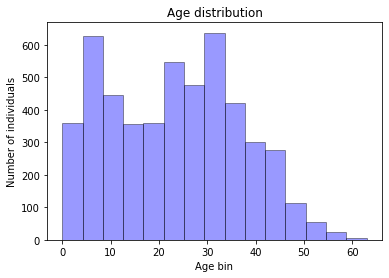

In [36]:
# seaborn histogram
sns.distplot(list(all_ind_age.values()), hist=True, kde=False, 
             bins=15, color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Age distribution')
plt.xlabel('Age bin')
plt.ylabel('Number of individuals')

### We set a geolocation point for every house and grocerie store

In [37]:
def getR2():
    u = getR()
    return 4*(u-0.5)*(u-0.5)*(u-0.5)+0.5

In [38]:
geo_hou = [ (getR(), getR()) for i in range(N_hou)]
geo_sto = [ (getR(), getR()) for i in range(N_sto)]

# Let's allocate a grocerie store for each house 

### I am begging you, do not reinvent the wheel...

In [39]:
distance, indexes = spatial.KDTree(geo_sto).query(geo_hou)

In [40]:
# House -> Grocerie store
all_hou_sto = dict(zip(range(N_hou), indexes))

In [41]:
# Grocerie store -> List of House
all_sto_hou = {}
for k, v in all_hou_sto.items():
    all_sto_hou[v] = all_sto_hou.get(v, [])
    all_sto_hou[v].append(k)

In [42]:
# Grocerie store -> List of Adults
all_sto_adu = {}
for k, v in all_hou_sto.items():
    all_sto_adu[v] = all_sto_adu.get(v, [])
    all_sto_adu[v].append(k)

In [43]:
md("There are %.2f individuals per house for a total of %d houses"%(
    pd.Series(all_ind_hou).value_counts().mean(), N_hou))

There are 3.53 individuals per house for a total of 1417 houses

# Let's finally choose a workplace for every individual

### Let's assume we have 44% of TPE, 42% of PME and 14% of GE in Morocco
Source : https://fnh.ma/article/actualite-economique/les-tpme-representent-93-des-entreprises-marocaines-en-2019

In [44]:
def pickWorkSize():
    p = getR()
    if p < 0.44:
        # We picked a TPE
        return int(1 + (TPE_MAX_EMPLOYEES-1)*getR())
    elif p < 0.86:
        # We picked a PME
        return int(TPE_MAX_EMPLOYEES + (PME_MAX_EMPLOYEES-TPE_MAX_EMPLOYEES)*getR())
    else:
        # We picked a PME
        return int(PME_MAX_EMPLOYEES + (GE_MAX_EMPLOYEES-PME_MAX_EMPLOYEES)*getR())

In [45]:
# Only adults work, and only half of them
workers = list([i for i in range(N) if getR() <0.5 and all_ind_adu[i]==1])
rand.shuffle(workers)
all_ind_wor = {}
i_ind = 0
i_wor = 0
while len(workers) > 0:
    for j in range(pickWorkSize()):
        if len(workers) == 0:
            break
        ind = workers.pop()
        all_ind_wor[ind] = i_wor
    i_wor = i_wor + 1

In [46]:
# workplace -> Individuals
all_wor_ind = {}
for k, v in all_ind_wor.items():
    all_wor_ind[v] = all_wor_ind.get(v, [])
    all_wor_ind[v].append(k)

In [47]:
N_wor = max(all_ind_wor.values()) # We set here the number of workplaces

In [48]:
md("There are %i workplaces in total"%(max(all_ind_wor.values())))

There are 146 workplaces in total

In [49]:
md("The %ith workplace has %i workers!!"%(
    pd.Series(all_ind_wor).value_counts().index[0], 
    pd.Series(all_ind_wor).value_counts().values[0]))

The 23th workplace has 49 workers!!

### We set a geolocation point for every house and grocerie store

In [50]:
geo_wor = [ (getR2(), getR2()) for i in range(N_wor)]

# Ok so let's summarize all we've got before going to COVID simulation

In [51]:
md("There are %i individuals"%(N))

There are 5000 individuals

In [52]:
md("There are %i houses"%(N_hou))

There are 1417 houses

In [53]:
md("There are %i grocerie stores"%(N_sto))

There are 70 grocerie stores

In [54]:
md("There are %i workplaces"%(N_wor))

There are 146 workplaces

In [55]:
md("""Each individual has an age (which will be helpful later). Example: \n 
Person %i is %i years old \n
Person %i is %i years old etc..."""%(154, all_ind_age[154], 99, all_ind_age[99]))

Each individual has an age (which will be helpful later). Example: 
 
Person 154 is 35 years old 

Person 99 is 37 years old etc...

In [56]:
md("""Each individual is linked to a house. Example: \n 
Person %i lives in house %i \n
Person %i lives in house %i etc..."""%(17, all_ind_hou[17], 23, all_ind_hou[23]))

Each individual is linked to a house. Example: 
 
Person 17 lives in house 5 

Person 23 lives in house 6 etc...

In [57]:
md("""Each individual works at a company. Example: \n 
Person %i works at company %i \n
Person %i works at company %i etc..."""%(
    list(all_ind_wor.keys())[3], all_ind_wor[list(all_ind_wor.keys())[3]], 
    list(all_ind_wor.keys())[7], all_ind_wor[list(all_ind_wor.keys())[7]]))

Each individual works at a company. Example: 
 
Person 444 works at company 0 

Person 4391 works at company 3 etc...

In [58]:
md("""Each house is linked to a grocerie store. Example: \n 
House %i is near store %i \n
House %i is near store %i etc..."""%(11, all_hou_sto[11], 27, all_hou_sto[27]))

Each house is linked to a grocerie store. Example: 
 
House 11 is near store 38 

House 27 is near store 55 etc...

# Ok, let's visualize all this mess

## Bubble sizes are the sum of individual (or houses) related to it

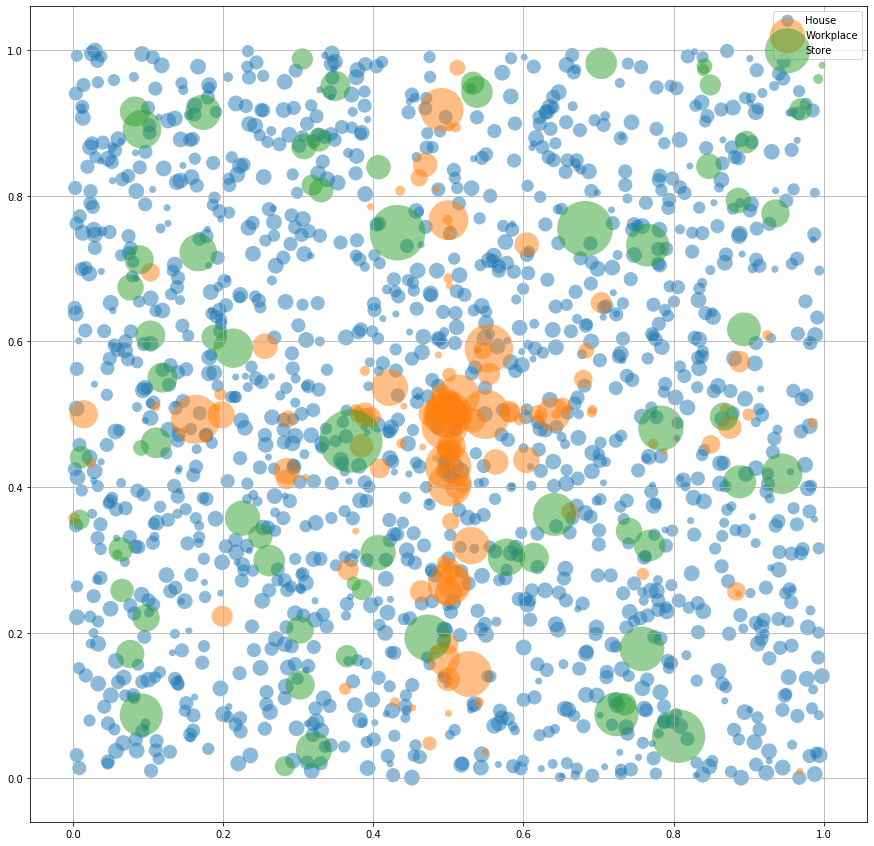

In [59]:
fig, ax = plt.subplots(figsize=(15, 15))
colors = ['tab:blue', 'tab:orange', 'tab:green']
    
scale_houses = 50*pd.Series(all_ind_hou).value_counts().sort_index().values # Size of each house
scale_workplaces = 50*pd.Series(all_ind_wor).value_counts().sort_index().values # Size of each house
scale_stores = 50*pd.Series(all_hou_sto).value_counts().sort_index().values # Size of each house

ax.scatter(np.array(geo_hou)[:,0], np.array(geo_hou)[:,1], c=colors[0], s=scale_houses, label="House", 
           alpha=0.5, edgecolors='none')
ax.scatter(np.array(geo_wor)[:,0], np.array(geo_wor)[:,1], c=colors[1], s=scale_workplaces, label="Workplace", 
           alpha=0.5, edgecolors='none')
ax.scatter(np.array(geo_sto)[:,0], np.array(geo_sto)[:,1], c=colors[2], s=scale_stores, label="Store", 
           alpha=0.5, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()

# Propagation functions

## Infection at home

In [60]:
def propagateToHouses(map_individuals_houses, map_houses_individuals, infection_state, contagion_state):
    # Houses that contain an infected and contagious person
    infected_houses = [map_individuals_houses[i] for i in getInfectedPeople(infection_state) 
                       if isContagious(i, contagion_state)]
    if DISPLAY:
        display(md("Which gives us %i infected different houses"%(len(infected_houses))))
    
    # People infected (not necessarily contagious) from a contagious person living in their house
    infected_athome = [i for i in flatten([map_houses_individuals[hou] for hou in infected_houses])
                            if getR() < PROB_INFECTION_AT_HOME]
    
    # INFECTION STATE UPDATE
    updateInfectionPeriod(infected_athome, infection_state, contagion_state)
    if DISPLAY:
        display(md("Ending at the morning with %i infected individuals"%(len(getInfectedPeople(infection_state)))))

In [61]:
def propagateToWorkplaces(map_individual_workers, map_workplace_individual, infection_state, contagion_state):
    # Contagious people who will go to work
    infected_gotowork = [i for i in getInfectedPeople(infection_state) if i in map_individual_workers.keys() 
                         and isContagious(i, contagion_state)]
    if DISPLAY:
        display(md("%i infected people go to work"%(len(infected_gotowork))))
        
    # Infected workplaces
    infected_workplaces = [map_individual_workers[ind] for ind in infected_gotowork]
    if DISPLAY:
        display(md("%i different work places are thus infected"%(len(infected_workplaces)))) 
    infected_backfromwork = [i for i in flatten([map_workplace_individual[k] for k in infected_workplaces]) 
                             if getR() < PROB_INFECTION_AT_WORK]
    
    # INFECTION STATE UPDATE
    updateInfectionPeriod(infected_backfromwork, infection_state, contagion_state)
    if DISPLAY:
        display(md("Ending at the morning with %i infected individuals"%(len(getInfectedPeople(infection_state)))))

In [62]:
def propagateToGroStores(map_individuals_houses, map_houses_stores, map_stores_houses, map_houses_adults, 
                         infection_state, contagion_state):
    # Filter on living people because we have a random choice to make in each house
    # People who will go to their store (one person per house as imposed by lockdown)
    individuals_gotostore = lazyRChoice([[i for i in map_houses_adults[h] if infection_state[i] != DEAD_STATE] 
                             for h in range(len(map_houses_adults))])
    if DISPLAY:
        display(md("In each house, a random adult goes to the store, which gives us %i individuals leaving"
               %(len(individuals_gotostore))))
    
    # Contagious people who will go to their store
    individuals_infected_gotostore = [i for i in individuals_gotostore if isContagious(i, contagion_state)]
    if DISPLAY:
        display(md("From which %i individuals are infected"%(len(individuals_infected_gotostore))))
    
    # Stores that will be visited by a contagious person
    infected_stores = [map_houses_stores[map_individuals_houses[i]] for i in individuals_infected_gotostore]
    if DISPLAY:
        display(md("%i grocerie stores are infected"%(len(infected_stores))))
    
    # People who live in a house that goes to a contagious store
    individuals_attachedto_infected_store = flatten(flatten(
        [[map_houses_adults[h] for h in map_stores_houses[s]] for s in infected_stores]))
    
    # People who did go to that contagious store
    individuals_goto_infected_store = list(set(individuals_attachedto_infected_store)
                                           .intersection(set(individuals_gotostore)))
    if DISPLAY:
        display(md("%i individuals went to an infected store"%(len(individuals_goto_infected_store))))
    
    # People who got infected from going to their store
    infected_backfromstore = [i for i in individuals_goto_infected_store if getR() < PROB_INFECTION_AT_STORE]
    
    # INFECTION STATE UPDATE
    updateInfectionPeriod(infected_backfromstore, infection_state, contagion_state)
    if DISPLAY:
        display(md("Ending at the morning with %i infected individuals"%(len(getInfectedPeople(infection_state)))))

# Let's innoculate 0.5% of the population the COVID-19 and start

In [65]:
inn_ind_cov = dict(zip(range(N), [int(getR() <= 0.005) for i in range(N)]))

In [66]:
# Infection dictionnary initialization
all_ind_inf = dict(zip(range(N), [-1]*N))
all_ind_con = dict(zip(range(N), [-1]*N))
ind_infected_init = [k for k,v in inn_ind_cov.items() if v==1]

for ind in ind_infected_init:
    # Incubation period between 2 and 14 days
    incubation, contagiosity = getInfectionParameters()
    all_ind_inf[ind] = incubation
    all_ind_con[ind] = contagiosity

In [67]:
living_infected_individuals_at_20pm = ind_infected_init

In [68]:
display(md("We start our cycle with %i infected individuals"%(len(getInfectedPeople(all_ind_inf)))))

We start our cycle with 31 infected individuals

# Let's start the infection cycle

In [69]:
stats = []
for _ in range(N_days):
    # INFECTION AT HOME
    propagateToHouses(all_ind_hou, all_hou_ind, all_ind_inf, all_ind_con)
    propagateToWorkplaces(all_ind_wor, all_wor_ind, all_ind_inf, all_ind_con)
    propagateToGroStores(all_ind_hou, all_hou_sto, all_sto_hou, all_hou_adu, all_ind_inf, all_ind_con)
    incrementInfectionDay(all_ind_inf, all_ind_age, all_ind_con)
    stats.append((len(getHealthyPeople(all_ind_inf)), 
                  len(getInfectedPeople(all_ind_inf)), 
                  len(getDeadPeople(all_ind_inf)),
                  len(getImmunePeople(all_ind_inf))))

# Some plots

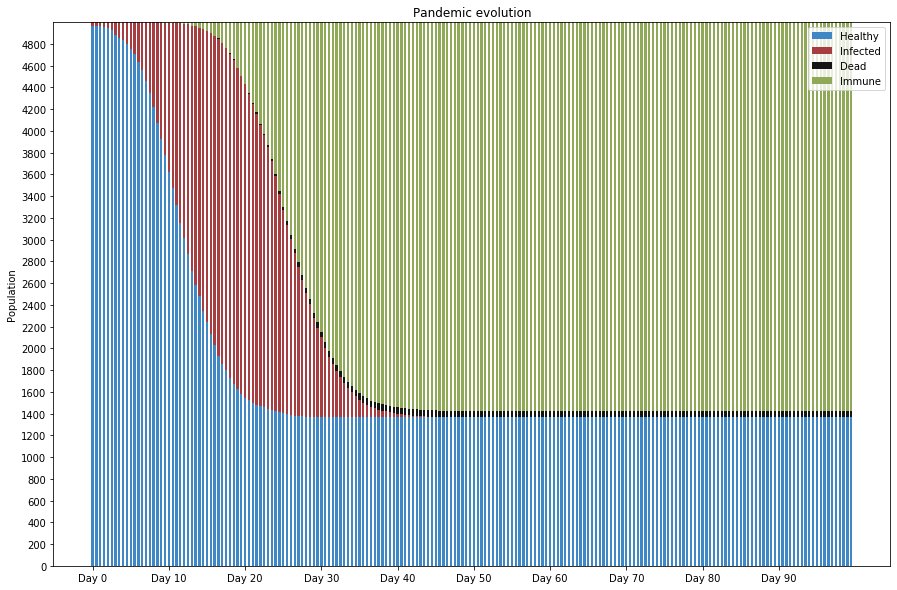

In [70]:
fig, ax = plt.subplots(figsize=(15, 10))

healthySerie = [stats[i][0] for i in range(N_days)]

infectedSerie = [stats[i][1] for i in range(N_days)]

deadSerie = [stats[i][2] for i in range(N_days)]
deadSerieStack = [stats[i][0] + stats[i][1] for i in range(N_days)]

immuneSerie = [stats[i][3] for i in range(N_days)]
immuneSerieStack = [stats[i][0] + stats[i][1] + stats[i][2] for i in range(N_days)]

ind = np.arange(N_days)
width = 0.6

p1 = plt.bar(ind, healthySerie, width, color="#3F88C5")
p2 = plt.bar(ind, infectedSerie, width, bottom=healthySerie, color="#A63D40")
p3 = plt.bar(ind, deadSerie, width, bottom=deadSerieStack, color="#151515")
p4 = plt.bar(ind, immuneSerie, width, bottom=immuneSerieStack, color="#90A959")

plt.ylabel('Population')
plt.title('Pandemic evolution')
plt.xticks(np.arange(0, N_days, int(N_days/10)), tuple([('Day ' + str(10*i)) for i in range(int(N_days/10))]))
plt.yticks(np.arange(0, N, N/25))
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Healthy', 'Infected', 'Dead', 'Immune'))

plt.show()

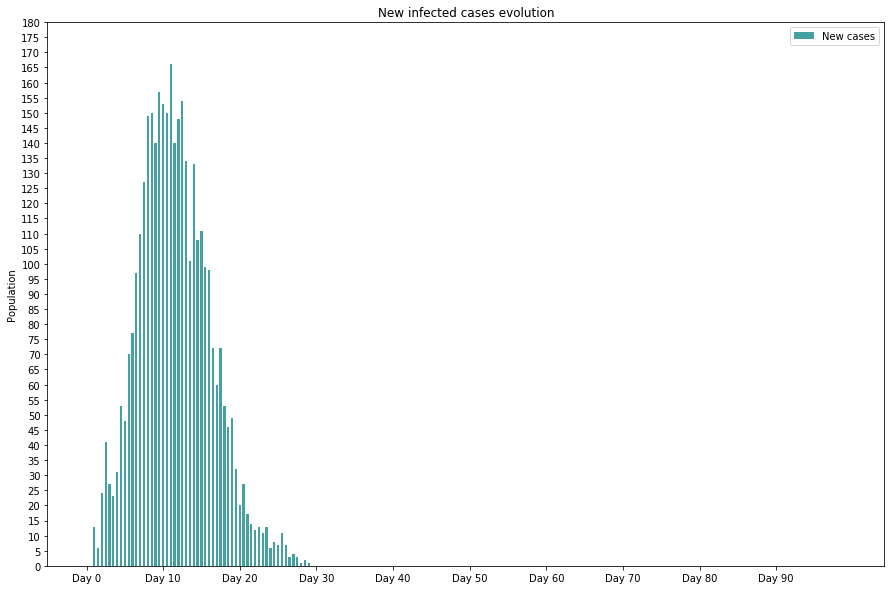

In [71]:
fig, ax = plt.subplots(figsize=(15, 10))

healthySerie = [stats[i][0] for i in range(N_days)]
newCasesSerie = list([j-i for (i,j) in zip(healthySerie[1:], healthySerie[:-1] )])

ind = np.arange(N_days-1)
width = 0.6

p1 = plt.bar(ind, newCasesSerie, width, color="#44A1A0")

plt.ylabel('Population')
plt.title('New infected cases evolution')
plt.xticks(np.arange(0, N_days-1, int(N_days/10)), tuple([('Day ' + str(10*i)) for i in range(int(N_days/10))]))
plt.yticks(np.arange(0, int(max(newCasesSerie)*1.1), 5))
plt.legend((p1[0],), ('New cases',))

plt.show()

In [72]:
stats

[(4969, 31, 0, 0),
 (4969, 31, 0, 0),
 (4969, 31, 0, 0),
 (4956, 44, 0, 0),
 (4950, 50, 0, 0),
 (4926, 74, 0, 0),
 (4885, 115, 0, 0),
 (4858, 142, 0, 0),
 (4835, 165, 0, 0),
 (4804, 196, 0, 0),
 (4751, 249, 0, 0),
 (4703, 297, 0, 0),
 (4633, 367, 0, 0),
 (4556, 444, 0, 0),
 (4459, 541, 0, 0),
 (4349, 651, 0, 0),
 (4222, 778, 0, 0),
 (4073, 927, 0, 0),
 (3923, 1077, 0, 0),
 (3783, 1213, 0, 4),
 (3626, 1369, 0, 5),
 (3473, 1522, 0, 5),
 (3323, 1666, 0, 11),
 (3157, 1832, 0, 11),
 (3017, 1966, 0, 17),
 (2869, 2111, 0, 20),
 (2715, 2254, 0, 31),
 (2581, 2381, 0, 38),
 (2480, 2469, 0, 51),
 (2347, 2588, 0, 65),
 (2239, 2677, 1, 83),
 (2128, 2769, 1, 102),
 (2029, 2846, 1, 124),
 (1931, 2919, 1, 149),
 (1859, 2951, 1, 189),
 (1799, 2967, 1, 233),
 (1727, 2985, 2, 286),
 (1674, 2980, 3, 343),
 (1628, 2949, 3, 420),
 (1579, 2924, 3, 494),
 (1547, 2882, 3, 568),
 (1527, 2813, 7, 653),
 (1500, 2751, 10, 739),
 (1483, 2676, 12, 829),
 (1469, 2584, 12, 935),
 (1457, 2503, 13, 1027),
 (1444, 2409, 